Version 1:

    Problem Statement: Find answers for StackOVerflow questions from Mapbox Documents.

In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
#import requests
#from bs4 import BeautifulSoup
import re
import os
import sys
from IPython.display import display, HTML
import re
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import regexp_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load StackOverflow Data 


In [39]:
df=pd.read_csv('preprocessed_v8.csv')
df.drop(labels=['Unnamed: 0','CreationDate','answered','answerId','link'],axis=1,inplace=True)
#using rows which have been answered (i.e) questions which have an AcceptedAnswerId
df=df[pd.notnull(df['AcceptedAnswerId'])]
df.head(2)

,Id,AcceptedAnswerId,questions,qTitle,tags,answerId,score,answers
2,48079262,48123703.0,I using style mapbox styles mapbox dark v9 Map...,Mapbox way to control label density,javascript mapbox mapbox-gl-js,48123703,2,The text padding symbol layout property It pro...
3,48098558,48099078.0,Messed Up Tiling I running issue I load tiles ...,Mapbox GL JS tiling faulty?,javascript mapbox mapbox-gl-js,48099078,1,sabas right Although appeared standard tileser...


In [40]:
print('Number of StackOVerflow questions: ', len(df))

Number of StackOVerflow questions:  610


# Extract Tags from 'Tags'

In [62]:
def split_tags(tag_string):
    tags=tag_string.split(" ")
    list_of_tags=[]
    #removing mapbox from tags column
    for tag in tags:
        if (tag!='mapbox') & (tag!=''):
            list_of_tags.append(tag)
    #returnString=" ".join(str(x) for x in list_of_tags)
    return list_of_tags# returnString

df['new_tags']=df['tags'].apply(split_tags)
df.head(2)

,Id,AcceptedAnswerId,questions,qTitle,tags,score,answers,new_tags,qTitle_tags
2,48079262,48123703.0,I using style mapbox styles mapbox dark v9 Map...,Mapbox way to control label density,javascript mapbox mapbox-gl-js,2,The text padding symbol layout property It pro...,"[javascript, mapbox-gl-js]","[density, label, way, mapbox, control]"
3,48098558,48099078.0,Messed Up Tiling I running issue I load tiles ...,Mapbox GL JS tiling faulty?,javascript mapbox mapbox-gl-js,1,sabas right Although appeared standard tileser...,"[javascript, mapbox-gl-js]","[j, tiling, gl, mapbox, faulty]"


# Extract Tags from 'qTitle'

In [63]:
#functions for pre-processing text
def cleanString(comment):
    #stopWords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(str(comment))
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) ]
                              #if w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list)
    
    return returnString

from rake_nltk import Rake
#extracting keyworkds from Subject and Description
def extract_key_words(string):
    r = Rake()
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    
    # extracting the words by passing the text
    r.extract_keywords_from_text(string)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    tags=list(key_words_dict_scores.keys())
    
    #removing mapbox from the tag list
    list_of_tags=[]
    for tag in tags:
        if (tag!='mapbox') & (tag!=''):
            list_of_tags.append(tag)
            
    #returnString=" ".join(str(x) for x in returnString)
    return list_of_tags#returnString

#to remove words not in the dictionary
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(str(sent)) \
     if w.lower() in words or not w.isalpha())



In [64]:
#df.drop(labels=['answerId'],axis=1,inplace=True)
df['qTitle_tags']=df['qTitle'].apply(cleanString)
df['qTitle_tags']=df['qTitle_tags'].apply(extract_key_words)
df['qTitle_tags']=df['qTitle_tags'].apply(remove_verbs)

df[['qTitle','qTitle_tags','tags','new_tags']].head()

,qTitle,qTitle_tags,tags,new_tags
2,Mapbox way to control label density,"[density, label, way, control]",javascript mapbox mapbox-gl-js,"[javascript, mapbox-gl-js]"
3,Mapbox GL JS tiling faulty?,"[j, tiling, gl, faulty]",javascript mapbox mapbox-gl-js,"[javascript, mapbox-gl-js]"
6,Open Map Tiles with mapbox-gl-js gives error a...,"[tile, zoom, js, error, higher, open, gl, map,...",mapbox-gl-js openmaptiles,"[mapbox-gl-js, openmaptiles]"
7,MapBox in Dialog shows with additional grey ov...,"[show, grey, additional, overlay, dialog]",java android mapbox,"[java, android]"
12,What do minzoom and maxzoom do in Mapbox-GL-JS...,"[exactly, js, minzoom, maxzoom, gl]",mapbox-gl-js vector-tiles,"[mapbox-gl-js, vector-tiles]"


In [68]:
#maybe also extract tags from question body and answer body, use that another layer of classification

# Analysis of Mapbox Document

edits on the csv file on Drive

- Removed the following columns:

 Type, external_id, image, published_at, updated_at, id, info, _index, _type, _score, _version, _explanations, sort
 
 
- Cleaned up rows and columns


In [80]:
#load mapbox doc
doc_data=pd.read_csv('mapbox_Documentation_All JSON.csv')
print('Length of data: ',len(doc_data))
doc_data.head(2)

Length of data:  587


,subsite,site,title,excerpt,url,contentType,codeLanguage/0,codeLanguage/1,body,sections/0,...,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237
0,Maps SDK for iOS,iOS,Default callout usage,Use default appearance and interactivity of an...,https://docs.mapbox.com/ios/maps/examples/defa...,example,Swift,Objective-C,Default callout usage If you are interested in...,Default callout usage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Mapbox GL JS,Create a draggable Marker,Drag the Marker to a new location on a map and...,https://docs.mapbox.com/mapbox-gl-js/example/d...,example,JavaScript,NaN,Create a draggable Marker Drag the Marker to a...,Create a draggable Marker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Sites 

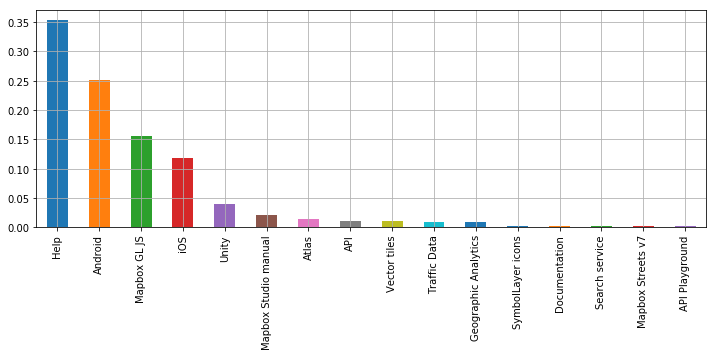

In [81]:
doc_data.site.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(12, 4))

# contentType

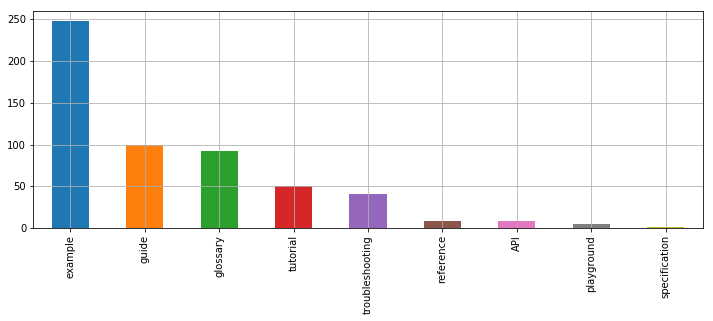

In [82]:
doc_data.contentType.value_counts(normalize=False).plot(kind='bar', grid=True, figsize=(12, 4))

# Language Type

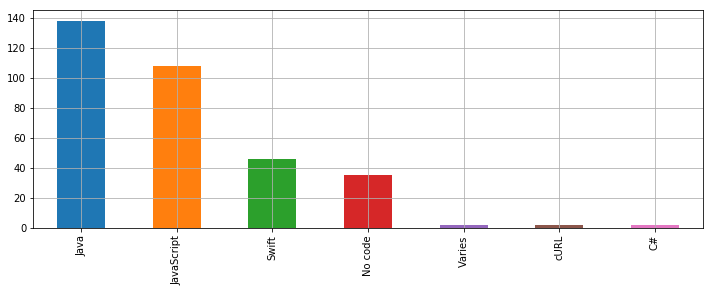

In [83]:
doc_data['codeLanguage/0'].value_counts(normalize=False).plot(kind='bar', grid=True, figsize=(12, 4))

# Create bag of Tags for key-word columns

In [118]:
#combine columns from site, subsite,contentType and codeLanguage
doc_data[['subsite', 'site','contentType','codeLanguage/0', 'codeLanguage/1']].head()

,subsite,site,contentType,codeLanguage/0,codeLanguage/1
0,Maps SDK for iOS,iOS,example,Swift,Objective-C
1,NaN,Mapbox GL JS,example,JavaScript,NaN
2,NaN,Mapbox GL JS,example,JavaScript,NaN
3,NaN,Help,tutorial,JavaScript,NaN
4,NaN,NaN,NaN,NaN,NaN


In [119]:
tags=[]
def remove_null(string):
    returnString=[]
    print(string)
    for word in string:
        if str(word).strip():
            returnString.append(word)
    print('-'*10,'\t',returnString)
    return returnString

for row in doc_data.iterrows():
    tag_list=[]
    tag_list.append(row[1].site)
    tag_list.append(row[1].contentType)
    tag_list.append(row[1]['codeLanguage/0'])
    tag_list.append(row[1].subsite)
    tag_list.append(row[1]['codeLanguage/1'])
    tag_list=remove_null(tag_list)
    tags.append(tag_list)

doc_data['tags']=tags
doc_data[['subsite', 'site','contentType','codeLanguage/0', 'codeLanguage/1','tags']].head(3)

['iOS', 'example', 'Swift', 'Maps SDK for iOS', 'Objective-C']
---------- 	 ['iOS', 'example', 'Swift', 'Maps SDK for iOS', 'Objective-C']
['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
---------- 	 ['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
---------- 	 ['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
['Help', 'tutorial', 'JavaScript', nan, nan]
---------- 	 ['Help', 'tutorial', 'JavaScript', nan, nan]
[nan, nan, nan, nan, nan]
---------- 	 [nan, nan, nan, nan, nan]
['Android', 'example', 'Java', 'Maps SDK for Android', nan]
---------- 	 ['Android', 'example', 'Java', 'Maps SDK for Android', nan]
['Help', 'glossary', nan, 'Glossary', nan]
---------- 	 ['Help', 'glossary', nan, 'Glossary', nan]
['iOS', 'example', 'Swift', 'Navigation SDK for iOS', nan]
---------- 	 ['iOS', 'example', 'Swift', 'Navigation SDK for iOS', nan]
['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
---------- 	 ['Mapbox GL JS', 'example', 'Ja

---------- 	 ['Help', 'guide', nan, 'How Mapbox works', nan]
['Android', nan, nan, 'Android Plugins', nan]
---------- 	 ['Android', nan, nan, 'Android Plugins', nan]
['Android', 'example', 'Java', 'Maps SDK for Android', nan]
---------- 	 ['Android', 'example', 'Java', 'Maps SDK for Android', nan]
['Help', 'glossary', nan, 'Glossary', nan]
---------- 	 ['Help', 'glossary', nan, 'Glossary', nan]
['Mapbox Studio manual', 'reference', nan, nan, nan]
---------- 	 ['Mapbox Studio manual', 'reference', nan, nan, nan]
['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
---------- 	 ['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
---------- 	 ['Mapbox GL JS', 'example', 'JavaScript', nan, nan]
['Help', 'guide', nan, nan, nan]
---------- 	 ['Help', 'guide', nan, nan, nan]
['Android', 'example', 'Java', 'Maps SDK for Android', nan]
---------- 	 ['Android', 'example', 'Java', 'Maps SDK for Android', nan]
['Android', 'example', 'Java', 'Map

---------- 	 ['Help', 'glossary', nan, 'Glossary', nan]
['Unity', 'example', 'No code', 'Maps SDK for Unity', nan]
---------- 	 ['Unity', 'example', 'No code', 'Maps SDK for Unity', nan]
['Android', 'guide', 'Java', 'Java SDK', nan]
---------- 	 ['Android', 'guide', 'Java', 'Java SDK', nan]
['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
---------- 	 ['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
['Android', 'example', 'Java', 'Maps SDK for Android', nan]
---------- 	 ['Android', 'example', 'Java', 'Maps SDK for Android', nan]
['Android', 'example', 'Java', 'Navigation SDK for Android', nan]
---------- 	 ['Android', 'example', 'Java', 'Navigation SDK for Android', nan]
['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
---------- 	 ['iOS', 'example', 'Swift', 'Maps SDK for iOS', nan]
['Help', 'glossary', nan, 'Glossary', nan]
---------- 	 ['Help', 'glossary', nan, 'Glossary', nan]
['Android', 'example', 'Java', 'Maps SDK for Android', nan]
---------- 	 ['Android', 'example

,subsite,site,contentType,codeLanguage/0,codeLanguage/1,tags
0,Maps SDK for iOS,iOS,example,Swift,Objective-C,"[iOS, example, Swift, Maps SDK for iOS, Object..."
1,NaN,Mapbox GL JS,example,JavaScript,NaN,"[Mapbox GL JS, example, JavaScript, nan, nan]"
2,NaN,Mapbox GL JS,example,JavaScript,NaN,"[Mapbox GL JS, example, JavaScript, nan, nan]"


,subsite,site,contentType,codeLanguage/0,codeLanguage/1,tags
0,Maps SDK for iOS,iOS,example,Swift,Objective-C,"[iOS, example, Swift, Maps SDK for iOS]"
1,NaN,Mapbox GL JS,example,JavaScript,NaN,"[Mapbox GL JS, example, JavaScript, nan]"
2,NaN,Mapbox GL JS,example,JavaScript,NaN,"[Mapbox GL JS, example, JavaScript, nan]"


# Compare Tags from StackOverflow with 

In [ ]:
codeLanguage/0

In [67]:
#to remove pronouns 
lines ="Mapbox GL JS tiling faulty"
print('Original Sentence: ',lines)
sentence=nltk.word_tokenize(lines)
tagged_sentence = nltk.tag.pos_tag(sentence)
print('Tagged Sentence: ',tagged_sentence)
list_of_tags=['NN']
edited_sentence = [word for word,tag in tagged_sentence if  tag in list_of_tags] 
print('Editted Sentence: ',edited_sentence)

Original Sentence:  Mapbox GL JS tiling faulty
Tagged Sentence:  [('Mapbox', 'NNP'), ('GL', 'NNP'), ('JS', 'NNP'), ('tiling', 'VBG'), ('faulty', 'NN')]
Editted Sentence:  ['faulty']
